In [1]:
# Import packages and other setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import datetime as dt
from sklearn.metrics import mean_squared_error
from scipy import stats
import pickle
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate
from bisect import bisect_left
import random
import itertools

In [2]:
plt.rcParams['figure.figsize'] = (15,10)
sns.set()

In [3]:
def moving_normal(num_episodes, samples_per_episode):
    val = np.empty((0))
    episode = np.empty((0))
    for i in range(num_episodes):
        val = np.append(val, np.random.normal(2 + 0.2*i, 1 + 0.1*i, samples_per_episode))
        episode = np.append(episode, np.full(samples_per_episode, i))
    df = pd.DataFrame()
    df['value'] = np.clip(val,0,10)
    df['value'].clip
    df['competing_bid'] = 1
    df['episode'] = episode
    return df

In [4]:
#ex. post optimal strategy
def hindsight_strategy(df, budget = 15):		
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df = df.sort_values(by = 'bang_per_buck', ascending=False)
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    shade = 1.0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            if row['competing_bid']==0:
                shade = np.infty
            else:
                shade = row['value']/row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
        else:
            break
    #print(shade)
    df['paced_bid'] = df['value']/shade
    df.sort_index(inplace=True)
    df['spend'] = df['competing_bid']*df['won']
    df['target_spend'] = df['spend']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0/shade
    #print(df.head())
    return df

In [5]:
#No regret adaptive pacing strategy
def adaptive_pacing_bg(df, target_spend, learning_rate = 0.001):
    """ A function to simulate an adaptive pacing strategy which attempts match the target spend

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        target_spend: instantaneous target spend (not cumulative)

    Returns:
        A dataframe containing with the following columns for each impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        target_spend: Target spend rate in this round
        utility: Utility obtained in this round
        paced_bid: Paced impression bid
        value_obtained: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data
    """
        
    max_shading = 100
    budget = np.sum(target_spend)
    cur_shading = 0.01
    df['pacing_multiplier'] = 0
    df['utility'] = 0
    df['won'] = False
    df['target_spend'] = target_spend
    df['paced_bid'] = 0
    df['spend'] = 0
    for index,row in df.iterrows():
        row['paced_bid'] = min(row['value']/(1 + cur_shading), budget)
        if row['paced_bid']==0:
            row['pacing_multiplier'] = 0
        else:
            row['pacing_multiplier'] = row['paced_bid']/row['value']
        if row['paced_bid']>=row['competing_bid']:
            budget = budget - row['competing_bid']
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            row['spend'] = row['competing_bid']
        cur_shading = cur_shading - learning_rate*(row['target_spend']-row['spend'])
        cur_shading = np.clip(cur_shading, a_min = 0, a_max = max_shading)
        df.loc[index] = row
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    #print(df.head())
    return df

In [6]:
#ex. post optimal strategy
def truthful_bidding(df, budget):
    """ A function to implement the ex. post optimal pacing strategy for a budget constraint campaign
    Sorts the impressions by value/competing bid and buys all top impressions till runs out of budget

    Args:
        df: The imput dataframe containing 'value' and 'competing_bid' with each row as one impression
        budget: The total budget for the campaign

    Returns:
        A dataframe containing with the following columns for each impression
        bang_per_buck: The value per dollar for the impression
        won: A binary flag indicating if the impression was won
        spend: Spend in this round
        utility: Utility obtained in this round
        paced_impression_bid: Paced bid
        value_obtianed: value_obtained in this round (i.e value*won)
        pacing_multiplier: The pacing multiplier used to obtained the shaded bid
        index: The index of the impression in the input data

    """
    df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
    df['utility'] = 0
    df['won'] = False
    df['spend'] = 0
    for index,row in df.iterrows():
        if budget-row['competing_bid'] >=0 and row['bang_per_buck']>0:
            row['won'] = True
            row['utility'] = row['value'] - row['competing_bid']
            budget = budget - row['competing_bid']
            df.loc[index] = row
    #print(shade)
    df['paced_bid'] = df['value']
    df['spend'] = df['competing_bid']*df['won']
    df['index'] = df.index
    df['value_obtained'] = df['value']*df['won']
    df['pacing_multiplier'] = 1.0
    #print(df.head())
    return df

# Spend rate estimation fixed price

In [7]:
def estimate_spend_rate(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    df['episode'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    df['bang_per_buck'] = df['value']/df['competing_bid']
    theta = estimate_theta(df, budget, num_episodes, T)
    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        df_e = df[df['episode']==e]
        bang_per_buck_cdf_e = ECDF(df_e['bang_per_buck'])
        spend_rate_e = 1 - bang_per_buck_cdf_e(theta)
        spend_rate_ep[e] = spend_rate_e
    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*100))
    spend_rates = np.repeat(spend_rate_ep,T) 
    spend_sum = np.sum(spend_rates)
    print(spend_rate_ep)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [8]:
def estimate_theta(df, budget, num_episodes, T):
    spend_per_round = budget/(num_episodes*T*df['competing_bid'].iloc[0])
    bang_per_buck_cdf = ECDF(df['bang_per_buck'])
    theta = smallest_x_with_cdf (bang_per_buck_cdf, 1 - spend_per_round)
    return theta

In [9]:
def smallest_x_with_cdf(cdf, cdf_thresh):
    eps = 1e-5
    l = 1.0
    r = 1.0
    while(cdf(r) <= cdf_thresh):
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (cdf(x) > cdf_thresh):
            r = x
        else:
            l = x
    return x

# Spend rate estimation, changing price

In [10]:
def estimate_spend_rate_cp(df_samples, budget, num_episodes, T):
    df = df_samples.copy()
    df['episode'] = np.repeat(range(num_episodes),df_samples.shape[0]/num_episodes)
    bandwidth = 0.1
    eps = 0.001
    episodic_spend_fn = {}
    for e in range(num_episodes):
        episodic_spend_fn[e] = {}
        episodic_spend_fn[e]['episode'] = e
        df_e = df[df['episode']==e]
        episodic_spend_fn[e]['price_kde'] = sm.nonparametric.KDEUnivariate(df_e['competing_bid'])
        episodic_spend_fn[e]['price_kde'].fit(bw=bandwidth)
        episodic_spend_fn[e]['value_ecdf'] = ECDF(df_e['value'])
        episodic_spend_fn[e]['upper_limit'] = episodic_spend_fn[e]['price_kde'].support[-1]
        episodic_spend_fn[e]['spend_bpb']  = lambda x: estimate_spend(episodic_spend_fn[e]['price_kde'],  episodic_spend_fn[e]['value_ecdf'], x, episodic_spend_fn[e]['upper_limit'])
       
        
    spend_per_round = budget/(num_episodes*T)

    
    theta = smallest_bpb_with_spend( lambda x: over_all_spend_bpb(episodic_spend_fn, x, num_episodes) , spend_per_round)
    print("Our multiplier %f"%theta)

    spend_rates = np.empty((0))
    spend_rate_ep = np.zeros(num_episodes)
    for e in range(num_episodes):
        spend_rate_e = episodic_spend_fn[e]['spend_bpb'](theta)
        spend_rate_ep[e] = spend_rate_e
    
    spend_rate_ep = spend_rate_ep.clip( min = 1/(num_episodes*10))
    for e in range(num_episodes):
        spend_rates = np.append(spend_rates, np.full(T, spend_rate_ep[e]))

    spend_sum = np.sum(spend_rates)
    print("spend_sum = %f"%spend_sum)
    print("budget = %f"%budget)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

In [11]:
def estimate_spend(price_kde, value_ecdf, bang_per_buck,  h=100):
    if(bang_per_buck < 1):
        bang_per_buck = 1
    spend_p = lambda x: (price_kde.evaluate(x)[0])*x*(1-value_ecdf(bang_per_buck*x))
    return integrate.quad(spend_p, 0, h)[0]

In [12]:
def over_all_spend_bpb(episodic_spend_fn, bang_per_buck, num_episodes):
    spend_c = 0
    for e in range(num_episodes):
        spend_this_episode = estimate_spend(episodic_spend_fn[e]['price_kde'], episodic_spend_fn[e]['value_ecdf'] , bang_per_buck,  episodic_spend_fn[e]['upper_limit'])
        spend_c = spend_c + spend_this_episode
    return spend_c/num_episodes

In [13]:
def smallest_bpb_with_spend(spend_fn, spend):
    eps = 1e-6
    l = 0
    r = 1.0
    cnt = 100
    while(spend_fn(r) > spend and cnt > 0):
        cnt = cnt -1 
        r = 2*r
    x = (l+r)/2
    while (r-l > eps):
        x = (l+r)/2
        if (spend_fn(x) < spend):
            r = x
        else:
            l = x
    return x

# Spend rate estimation using hindsight as an oracle

In [14]:
def spend_rate_using_hindsight(df_samples, budget, num_episodes, T, num_trials = 10, sampling_probability = 0.5):
    
    dataset = df_samples.copy()
    total_impressions = dataset.shape[0]
    num_samples = int(total_impressions*sampling_probability)
    spend_per_round = budget/(num_episodes*T)
    
    scaled_budget = spend_per_round*sampling_probability*total_impressions
    spend_rate_ep = np.zeros(num_episodes)
    for _i in range(num_trials):
        sampling_indices = sorted(np.random.choice(total_impressions, num_samples, replace=False))
        sampled_data = dataset.iloc[sampling_indices]
        dft = hindsight_strategy(sampled_data, scaled_budget)
        for e in range(num_episodes):
            spend_rate_ep[e] += dft.loc[dft['episode'] == e, 'spend'].mean()


    spend_rate_ep = [x/num_trials for x in spend_rate_ep]

    spend_rates = np.empty((0))
    for e in range(num_episodes):
        spend_rates = np.append(spend_rates, np.full(T, spend_rate_ep[e]))

    spend_sum = np.sum(spend_rates)
    print("spend_sum = %f"%spend_sum)
    print("budget = %f"%budget)
    if spend_sum != 0:
        spend_rates = (spend_rates/spend_sum)*budget
    return spend_rates

## Linear spend rate

In [15]:
def linear_spend_rate(budget, num_rounds):
    """
    Linear OC. Assumes interarrival time between the impressions is uniform.
    
    Args:
        budget: budget to be divided
        num_rounds: number of rounds the budget needs to be divided into

    Returns:
        Linear (OC)
        
    """
    
    return [budget/num_rounds]*num_rounds

In [16]:
def change_OC(df_in):
    df = df_in.copy()
    mapping = {'fixed_p': 'Fixed pacing','lin' : 'Fixed spend (BG19)', 'dist' : 'Changing spend (this)', 'hindsight':'Optimal', 'truthful': 'Truthful'}
    df['Algorithm'] = ""
    for i in range(df_in.shape[0]):
        df['Algorithm'].iloc[i] = mapping[ df['OC'].iloc[i]] 
    return df

## Regret (not used in experiments as of now)

In [17]:
def paced_regret_u(hindsight_df, pacing_df):
    """
    Final utility regret. Returns percent regret measured with respect to the hindsight value
    """
    hindsight_total_val = hindsight_df['utility'].sum()
    paced_total_val = pacing_df['utility'].sum()
    return ((hindsight_total_val - paced_total_val)*100/hindsight_total_val)

# Facebook data

# <span style='color:red'> Change the following 2 functions!!!  </span> 

In [18]:
def get_fb_data(campaigns,num_episodes, T, training_samples_per_episode):
    campaign = random.choice(campaigns)
    print(campaign)
    episode_length_minutes =  (24*60)/num_episodes
    test_data = get_transformed_data_from_campaign(campaign,  T, episode_length_minutes)
    
    training_data = get_transformed_data_from_campaign(campaign, training_samples_per_episode, episode_length_minutes)
    
    return test_data, training_data

### <span style='color:red'> The followig function is just a dummy, use the function that returns fixed impressions per bucket transform instead of following </span> 

In [19]:
def get_transformed_data_from_campaign(campaign,samples_per_episode, episode_length_minutes):
    num_episodes = int((24*60)/episode_length_minutes)
    return moving_normal(num_episodes, samples_per_episode)

In [20]:
campaigns = ['1', '2'] #campaign names as strings

# Experiment script

In [21]:
columns_plot = ['utility', 'spend']

In [22]:
dataset = 'fb_campaigns'
data_oracle = lambda num_episodes, T, training_samples_per_episode: get_fb_data(campaigns,num_episodes, T, training_samples_per_episode)
#spend_rate_estimation_oracle = estimate_spend_rate_cp
spend_rate_estimation_oracle = spend_rate_using_hindsight

## Set num episodes appropriately, maybe 24

In [23]:
T = 100 #Number of impressions in each episode
num_episodes = 10 #Number of episodes
training_samples_per_episode = 100

In [24]:
df_utility_res = {}
df_utility_res[dataset] = pd.DataFrame (columns = ['utility', 'utility_h', 'budget_frac', 'OC']) 

In [25]:
OCs =['truthful','lin','dist']

In [26]:
num_exp = 5 #number of times the experiment to be repeated
learning_rate = 0.1

## Set num_exp = 1 and uncomment the end of the following block to see what the graph for the one instance looks like if needed for debugging. Use  num_exp = 150 for the main run


In [27]:
for exp_c in range(num_exp):
    if exp_c%5==0:
        print(exp_c)

    data, training_data = data_oracle(num_episodes, T, training_samples_per_episode)
    budget_frac = np.random.uniform(0,1.5)
    budget_total = data[data['value'] > data['competing_bid'] ]['competing_bid'].sum()
    print("budget_frac = %f"%budget_frac)
    budget = budget_total*budget_frac
    target_dist_spend = spend_rate_estimation_oracle(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
    target_lin_spend = linear_spend_rate(budget, num_episodes*T)
    paced_df = {}
    paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
    utility_h = paced_df['hindsight']['utility'].sum()
    for OC in OCs:
        if OC == 'lin':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_lin_spend, learning_rate)
        elif OC == 'dist':
            adaptive_pacing_df = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
        elif OC == 'truthful':
            adaptive_pacing_df = truthful_bidding(data.copy(), budget = budget)
        else:
            raise NameError('Invalid OC type')
        paced_df[OC] = adaptive_pacing_df.copy()
        row = {'utility' : adaptive_pacing_df["utility"].sum(), 'utility_h' : utility_h, 'budget_frac' : budget_frac, 'OC' : OC}
        df_utility_res[dataset] = df_utility_res[dataset].append(row,ignore_index=True)

#     df_cum = paced_df['hindsight'][ columns_plot ].cumsum()
#     df_cum['index'] = df_cum.index
#     df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
#     df_tidy['OC'] = 'hindsight'
#     df_plot = df_tidy.copy()
#     for OC in OCs:
#         df_cum = paced_df[OC][ columns_plot ].cumsum()
#         df_cum['index'] = df_cum.index
#         df_tidy =  pd.melt(df_cum, id_vars=['index'], var_name='cols', value_name = 'cumm_value')
#         df_tidy['OC'] = OC
#         df_plot = pd.concat([df_plot, df_tidy])
#     df_plot['col'] = df_plot[['cols', 'OC']].apply(lambda x: '_'.join(x), axis = 1)

#     ax = sns.relplot(
#     x ='index',
#     y ='cumm_value',
#     kind ='line',
#     hue = 'col',
#     height = 8,
#     data = df_plot
#     )
#     ax.set(xlabel='t', ylabel='Cummulative magnitude', title=('Performance on ' + dataset + ' dataset'))



0
2
budget_frac = 0.249083


<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

spend_sum = 222.312471
budget = 223.178384
2
budget_frac = 0.770080


<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

spend_sum = 685.194122
budget = 688.451348
1
budget_frac = 0.376496


<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

spend_sum = 328.598957
budget = 328.304786
2
budget_frac = 1.017369


<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

spend_sum = 898.316329
budget = 919.701168
2
budget_frac = 0.452499


<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bang_per_buck'] = (df['value'] - df['competing_bid'])/df['competing_bid']
<ipython-input-4-3530d2f7aea3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

spend_sum = 396.983788
budget = 401.367049


In [28]:
df_utility_res[dataset]['fractional_ut'] = df_utility_res[dataset]['utility']/df_utility_res[dataset]['utility_h']
df_utility_res[dataset]['dataset'] = dataset

In [31]:
res_addr = '/home/ubuntu/work/pacing/data/res/' + dataset +'.pkl'
plot_addr_base = '/home/ubuntu/work/pacing/data/plots/'

In [ ]:
# Save to pickle for backup
df_utility_res[dataset].to_pickle(res_addr)

In [ ]:
#load backup if needed
df_utility_res[dataset]  = pd.read_pickle(res_addr)

/home/ubuntu/work/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


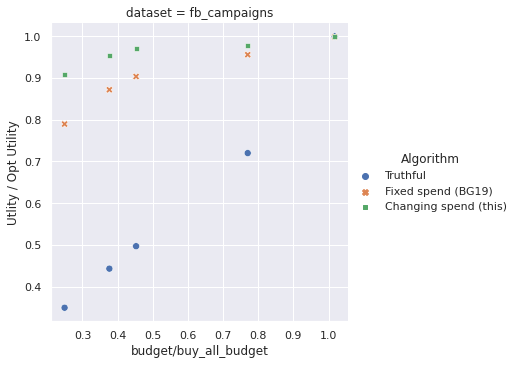

In [32]:
ax = sns.relplot(
    x ='budget_frac',
    y ='fractional_ut',
    kind = 'scatter',
    hue = 'Algorithm',
    style="Algorithm",
    col = "dataset",
    height = 5,
    col_wrap=1,
    data = change_OC(df_utility_res[dataset]),
    s= 50,
    legend = True
    )

ax.set(xlabel='budget/buy_all_budget' , ylabel='Utlity / Opt Utility')
plt.savefig(plot_addr_base + dataset + ".eps",dpi=300, bbox_inches='tight')

In [55]:
spend_rate_estimation_oracle = estimate_spend_rate_cp

In [63]:
num_repeat = 10

In [64]:
df_samplesize_res = {}
df_samplesize_res[dataset] = pd.DataFrame (columns = ['fractional_ut', 'budget_frac', 'num_samples']) 

In [65]:
training_sizes = [1,10,50,100,300]
budget_fractions = [0.25, 0.5, 0.75, 1, 1.25]

In [67]:
for budget_frac in budget_fractions:
    print("budget_frac = %f"%budget_frac)
    for training_samples_per_episode in training_sizes:
        print("num_samples = %f"%training_samples_per_episode)
        fractional_utility = []
        for exp_c in range(num_repeat):
            data, training_data = data_oracle(num_episodes, T, training_samples_per_episode)
            budget_total = data[data['value'] > data['competing_bid'] ]['competing_bid'].sum()
            budget = budget_total*budget_frac
            target_dist_spend = spend_rate_estimation_oracle(df_samples = training_data, budget = budget, num_episodes = num_episodes, T = T)
            paced_df = {}
            paced_df['hindsight'] = hindsight_strategy(data, budget = budget)
            utility_h = paced_df['hindsight']['utility'].sum()
            paced_df['dist'] = adaptive_pacing_bg(data.copy(), target_dist_spend, learning_rate)
            utility_d = paced_df['dist']["utility"].sum()
            fractional_utility = fractional_utility + [utility_d/utility_h]
        row = {'fractional_ut' : np.mean(fractional_utility), 'budget_frac' : budget_frac, 'num_samples' : training_samples_per_episode}
        df_samplesize_res[dataset] = df_samplesize_res[dataset].append(row,ignore_index=True)

budget_frac = 0.250000
num_samples = 1.000000
1
Our multiplier 5.163064
spend_sum = 229.151263
budget = 223.500000
2
Our multiplier 4.401135
spend_sum = 233.647098
budget = 227.750000
1
Our multiplier 4.090455
spend_sum = 228.499825
budget = 223.500000
num_samples = 10.000000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 3.943698
spend_sum = 227.499948
budget = 227.500000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 3.910619
spend_sum = 222.749734
budget = 222.750000
1


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 4.126689
spend_sum = 226.750111
budget = 226.750000
num_samples = 100.000000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 4.109900
spend_sum = 223.249809
budget = 223.250000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 4.012792
spend_sum = 227.694222
budget = 227.750000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 4.107352
spend_sum = 225.468155
budget = 225.500000
budget_frac = 0.500000
num_samples = 1.000000
2
Our multiplier 2.796443
spend_sum = 438.303932
budget = 435.000000
1
Our multiplier 2.732108
spend_sum = 440.444124
budget = 437.000000
2
Our multiplier 4.218860
spend_sum = 444.999949
budget = 441.000000
num_samples = 10.000000
1


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 3.154796
spend_sum = 453.492995
budget = 453.500000
1


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 2.998939
spend_sum = 450.999647
budget = 451.000000
1


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 3.399009
spend_sum = 446.496265
budget = 446.500000
num_samples = 100.000000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 2.994662
spend_sum = 438.515750
budget = 438.500000
1


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 2.877978
spend_sum = 445.012891
budget = 445.000000
2


<ipython-input-11-bf10377201d2>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(spend_p, 0, h)[0]


Our multiplier 2.875724
spend_sum = 455.001915
budget = 455.000000


In [69]:
df_samplesize_res[dataset]['dataset'] = dataset

In [94]:
df_samplesize_res[dataset]['budget_frac']  = df_samplesize_res[dataset]['budget_frac'] .astype(str)

[Text(0.5, 0, 'num training samples'), Text(0, 0.5, 'Utlity / Opt Utility')]

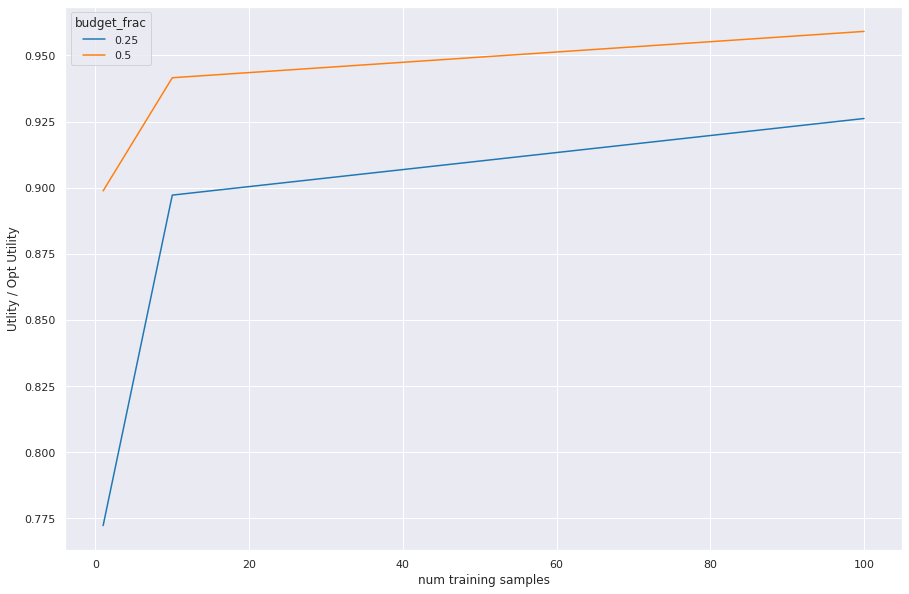

In [95]:
ax = sns.lineplot(
    x ='num_samples',
    y ='fractional_ut',
    hue = 'budget_frac',
    #style="budget_frac",
    data = df_samplesize_res[dataset],
    legend = True,
    ci = None
    )

ax.set(xlabel='num training samples' , ylabel='Utlity / Opt Utility')